In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from pandas.io.formats.style import Styler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [60]:
df = pd.read_csv('bank.csv', sep=';')

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

# Data Preprocessing

In [62]:
# Transform the dependent variable
df.y = np.where(df['y'] == 'yes', 1, 0)
df.y.value_counts()

y
0    3668
1     451
Name: count, dtype: int64

In [63]:
# Isolate the x and y
X = df.select_dtypes(include=[np.number]).drop('y', axis = 1)
y = df.y

In [64]:
X.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,30,487,2,999,0,-1.8,92.893,-46.2,1.313,5099.1
1,39,346,4,999,0,1.1,93.994,-36.4,4.855,5191.0
2,25,227,1,999,0,1.4,94.465,-41.8,4.962,5228.1
3,38,17,3,999,0,1.4,94.465,-41.8,4.959,5228.1
4,47,58,1,999,0,-0.1,93.200,-42.0,4.191,5195.8


In [65]:
# Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1502)

In [66]:
# Create DMatrix for XGBoost
train = xgb.DMatrix(X_train, label = y_train)
test = xgb.DMatrix(X_test, label = y_test)

# XGBoost

In [67]:
# Set the params for XGBoost model
parameters = {
    'objective': 'binary:logistic',
    'max_depth': 2,
    'learning_rate': 0.3,
    'n_estimators': 100,
    'subsample': 1,
    'colsample_bytree': 1,
    'min_child_weight': 1,
    'gamma': 0,
    'random_state': 1502,
    'eval_metric': ['auc','aucpr']
}

In [68]:
# Train the XGBoost model
model1 = xgb.train(params = parameters, 
                   dtrain = train,
                   num_boost_round = 100,
                   evals = [(test,'Test')],
                   verbose_eval = 10,
                   early_stopping_rounds = 10
                   )

[0]	Test-auc:0.86380	Test-aucpr:0.46694
[10]	Test-auc:0.92826	Test-aucpr:0.56168
[20]	Test-auc:0.92797	Test-aucpr:0.56038
[23]	Test-auc:0.92794	Test-aucpr:0.56400


In [69]:
# Make predictions
predictions1 = model1.predict(test)
predictions1 = np.where(predictions1>0.5,1,0)
predictions1[:5]

array([0, 0, 0, 0, 0])

In [75]:
# Calculate the confusion matrix and classification report
confusion_matrix1 = confusion_matrix(y_test, predictions1)
report1 = classification_report(y_test, predictions1, output_dict=True)
report1

{'0': {'precision': 0.931909212283044,
  'recall': 0.953551912568306,
  'f1-score': 0.9426063470627954,
  'support': 732.0},
 '1': {'precision': 0.5466666666666666,
  'recall': 0.44565217391304346,
  'f1-score': 0.49101796407185627,
  'support': 92.0},
 'accuracy': 0.8968446601941747,
 'macro avg': {'precision': 0.7392879394748553,
  'recall': 0.6996020432406747,
  'f1-score': 0.7168121555673259,
  'support': 824.0},
 'weighted avg': {'precision': 0.888896695054031,
  'recall': 0.8968446601941747,
  'f1-score': 0.8921862848841955,
  'support': 824.0}}

In [74]:
pd.DataFrame(report1)

,0,1,accuracy,macro avg,weighted avg
precision,0.931909,0.546667,0.896845,0.739288,0.888897
recall,0.953552,0.445652,0.896845,0.699602,0.896845
f1-score,0.942606,0.491018,0.896845,0.716812,0.892186
support,732.000000,92.000000,0.896845,824.000000,824.000000


In [81]:
# Print the main KPI for minority class
print(f"Precision: {report1['1']['precision']:.2f}")
print(f"Recall: {report1['1']['recall']:.2f}")
print(f"F1 Score: {report1['1']['f1-score']:.2f}")

Precision: 0.55
Recall: 0.45
F1 Score: 0.49


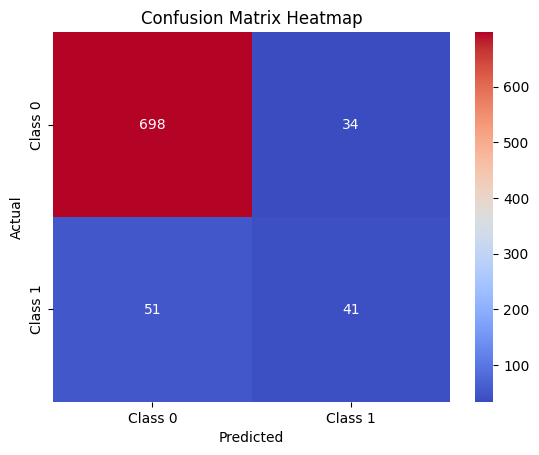

In [91]:
# Visualise the confusion matrix
sns.heatmap(confusion_matrix1,
            annot=True,
            cmap = 'coolwarm',
            fmt='g',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix Heatmap")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [30]:
numerical_summary = df.describe().transpose()

palette = sns.color_palette("viridis", as_cmap=True)

numerical_summary.style.background_gradient(cmap=palette)

,count,mean,std,min,25%,50%,75%,max
age,4119.000000,40.113620,10.313362,18.000000,32.000000,38.000000,47.000000,88.000000
duration,4119.000000,256.788055,254.703736,0.000000,103.000000,181.000000,317.000000,3643.000000
campaign,4119.000000,2.537266,2.568159,1.000000,1.000000,2.000000,3.000000,35.000000
pdays,4119.000000,960.422190,191.922786,0.000000,999.000000,999.000000,999.000000,999.000000
previous,4119.000000,0.190337,0.541788,0.000000,0.000000,0.000000,0.000000,6.000000
emp.var.rate,4119.000000,0.084972,1.563114,-3.400000,-1.800000,1.100000,1.400000,1.400000
cons.price.idx,4119.000000,93.579704,0.579349,92.201000,93.075000,93.749000,93.994000,94.767000
cons.conf.idx,4119.000000,-40.499102,4.594578,-50.800000,-42.700000,-41.800000,-36.400000,-26.900000
euribor3m,4119.000000,3.621356,1.733591,0.635000,1.334000,4.857000,4.961000,5.045000
nr.employed,4119.000000,5166.481695,73.667904,4963.600000,5099.100000,5191.000000,5228.100000,5228.100000


In [244]:
missing_data = df.isnull().sum()

missing_data = missing_data[missing_data>0]

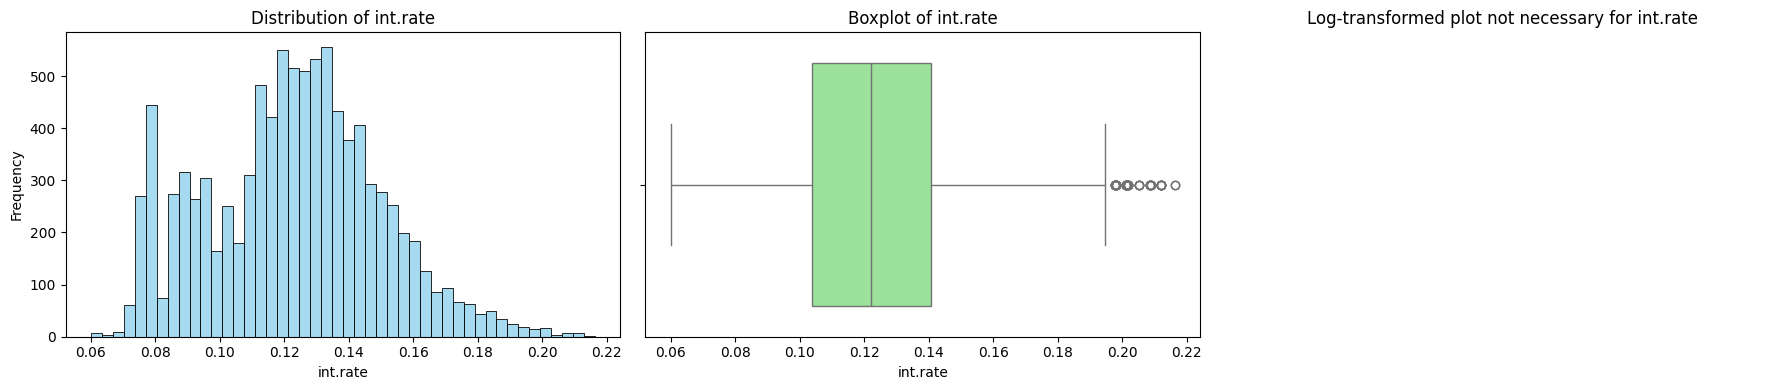

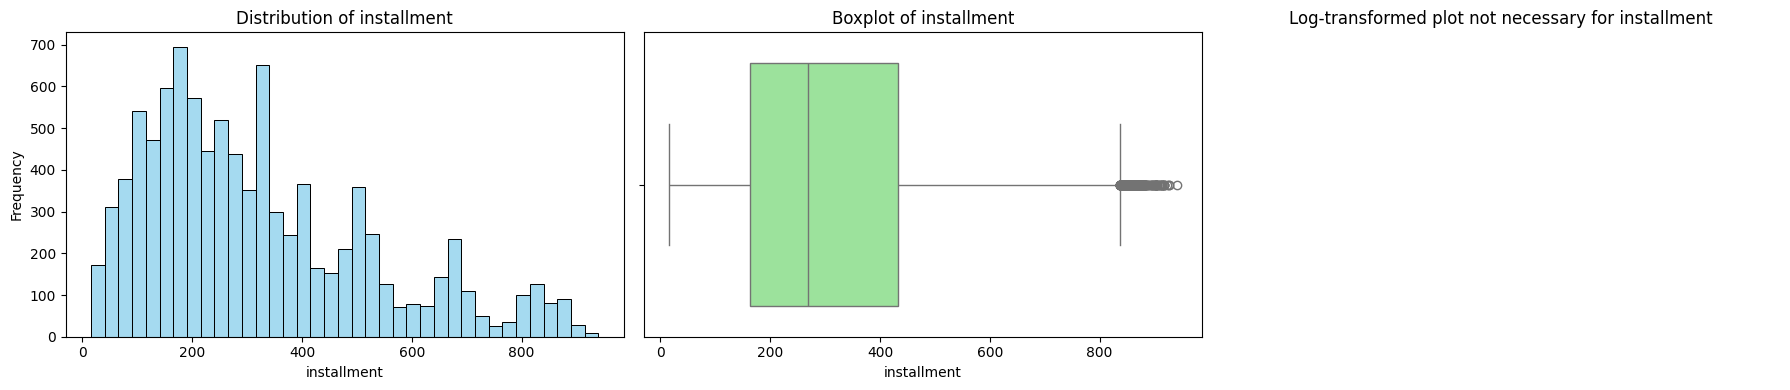

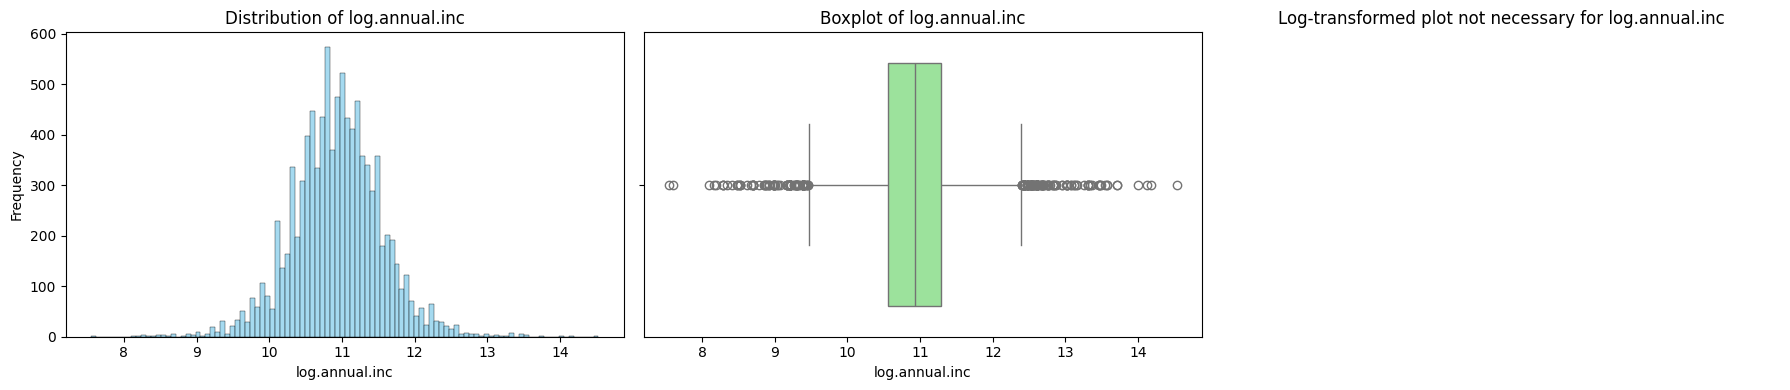

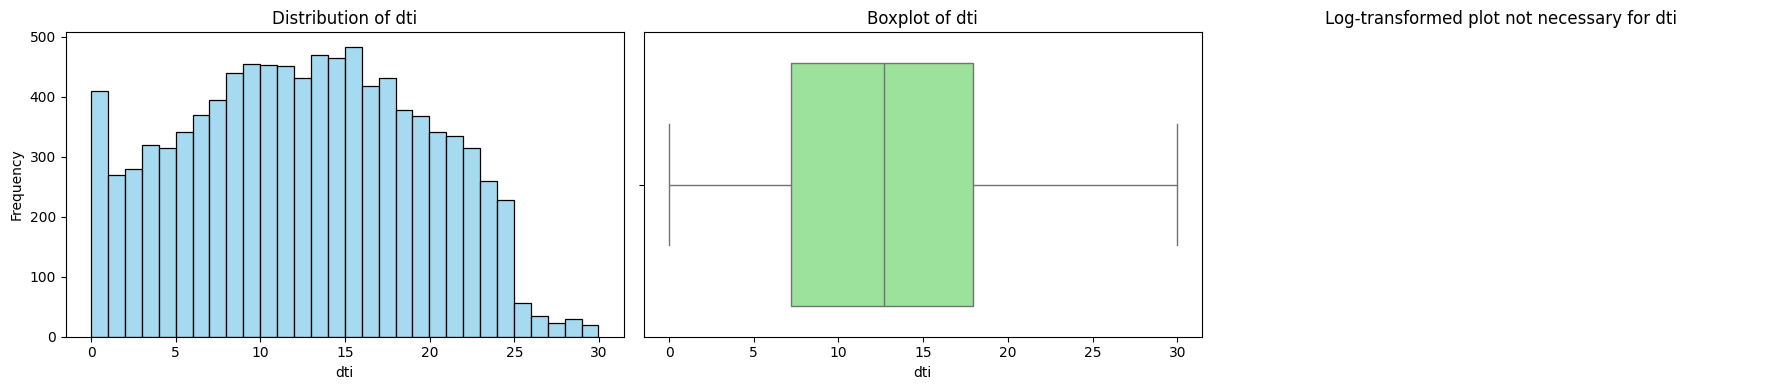

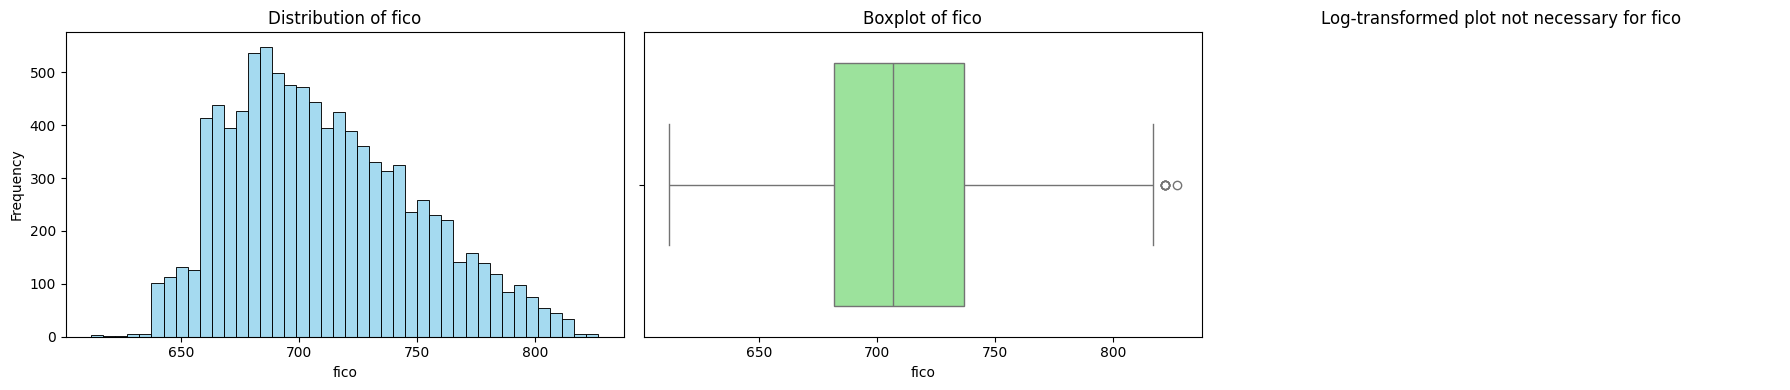

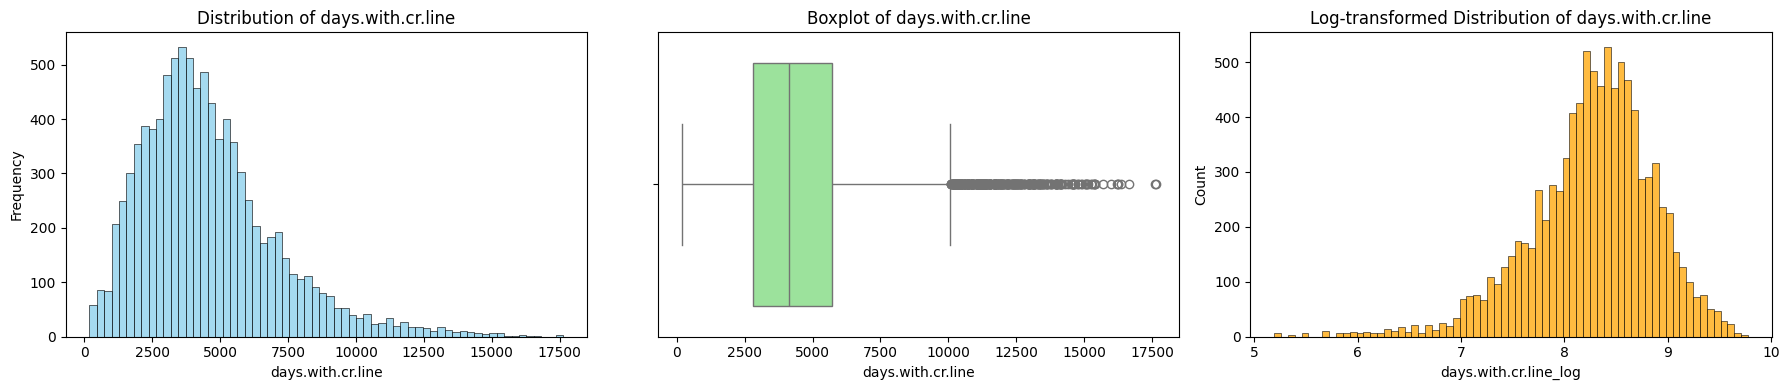

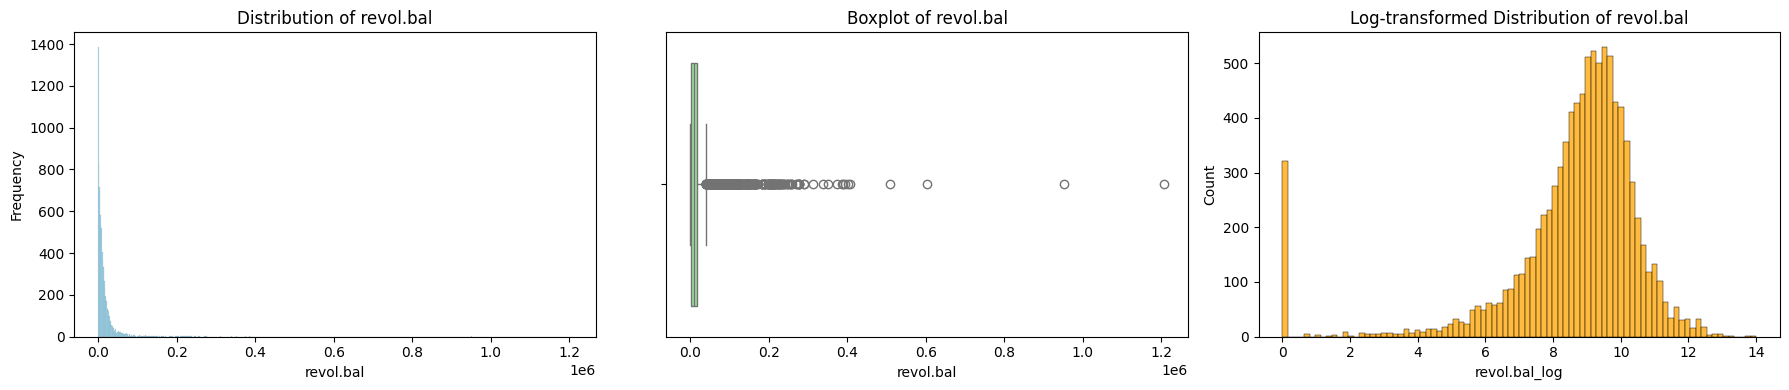

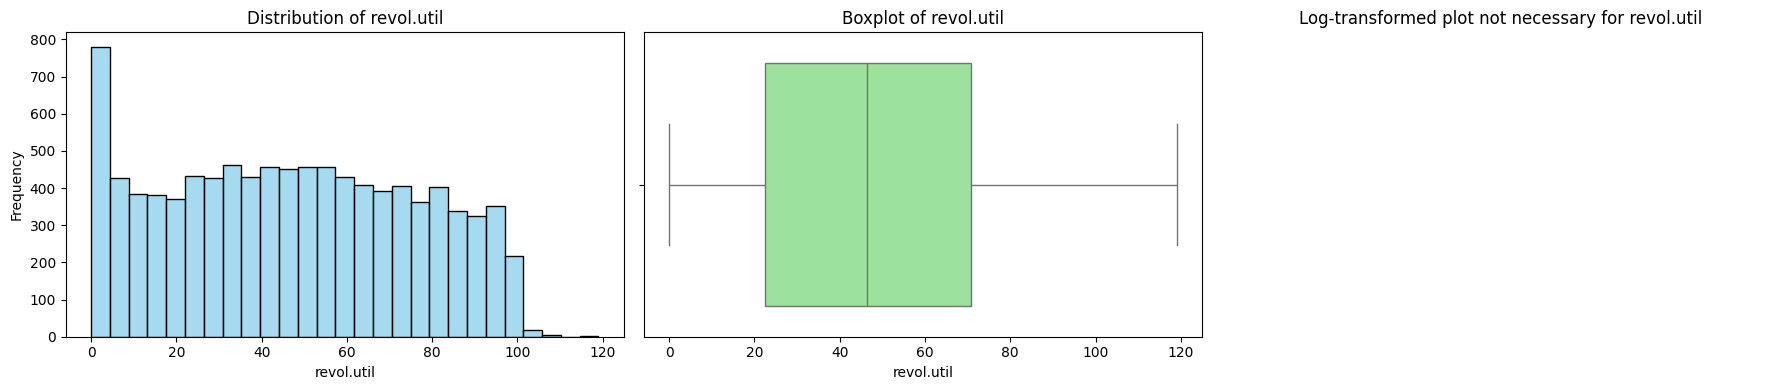

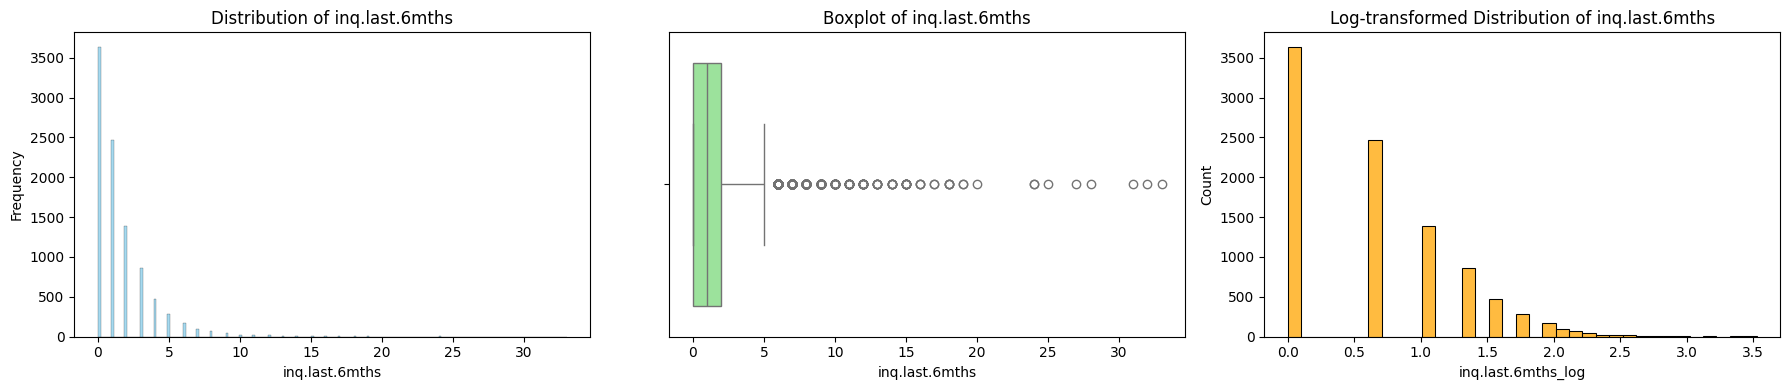

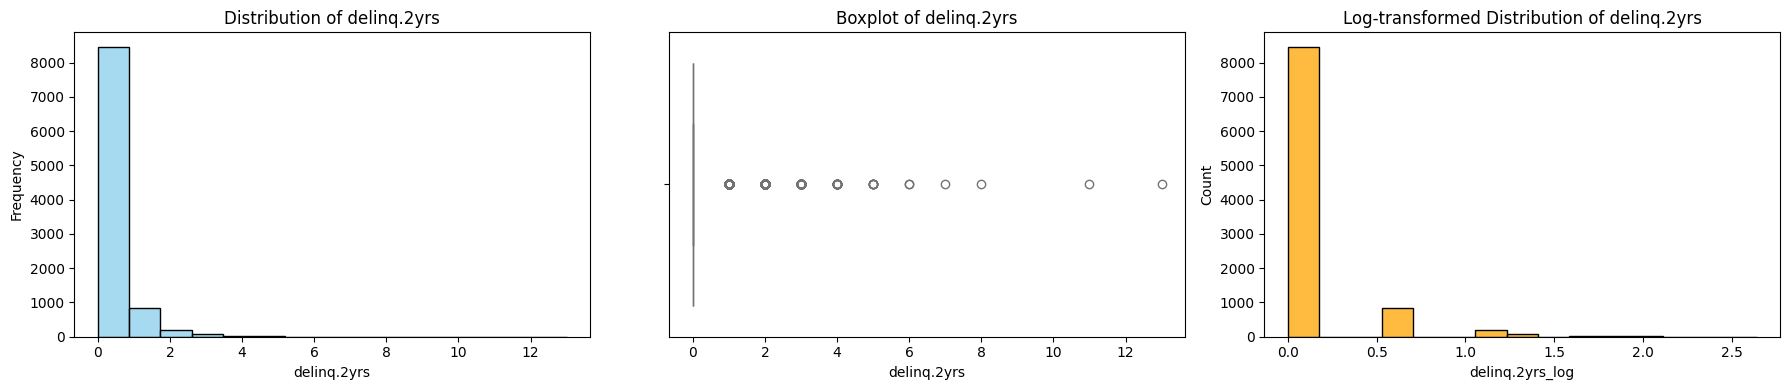

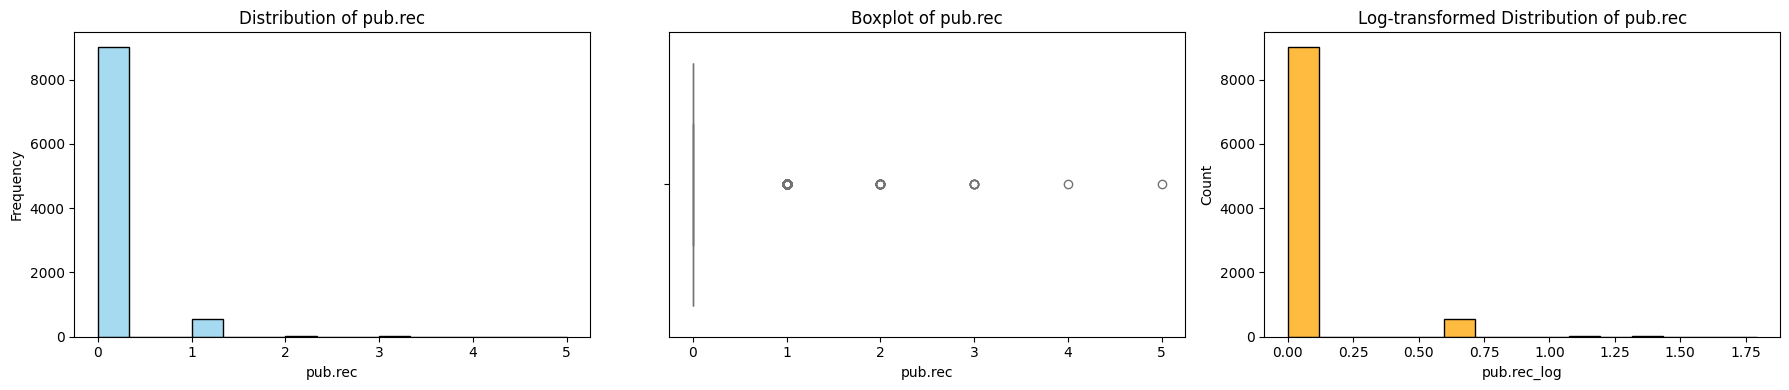

In [238]:
non_boolean_numerical_features = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 
                                  'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 
                                  'delinq.2yrs', 'pub.rec']
boolean_numeric_features = ['credit.policy', 'not.fully.paid']

# Visualize the distributions and box plots for numerical features, including log-transformed versions for skewed data
for column in non_boolean_numerical_features:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

    # Histogram for the distribution
    sns.histplot(df[column], kde=False, color='skyblue', ax=ax1)
    ax1.set_title(f'Distribution of {column}')
    ax1.set_ylabel('Frequency')

    # Boxplot for the variable
    sns.boxplot(x=df[column], color='lightgreen', ax=ax2)
    ax2.set_title(f'Boxplot of {column}')

    # Log transformation and plot if the data is skewed
    if df[column].skew() > 1:
        df[column+'_log'] = np.log1p(df[column])
        sns.histplot(df[column+'_log'], kde=False, color='orange', ax=ax3)
        ax3.set_title(f'Log-transformed Distribution of {column}')
    else:
        ax3.set_title(f'Log-transformed plot not necessary for {column}')
        ax3.axis('off')

    plt.tight_layout()
    plt.show()

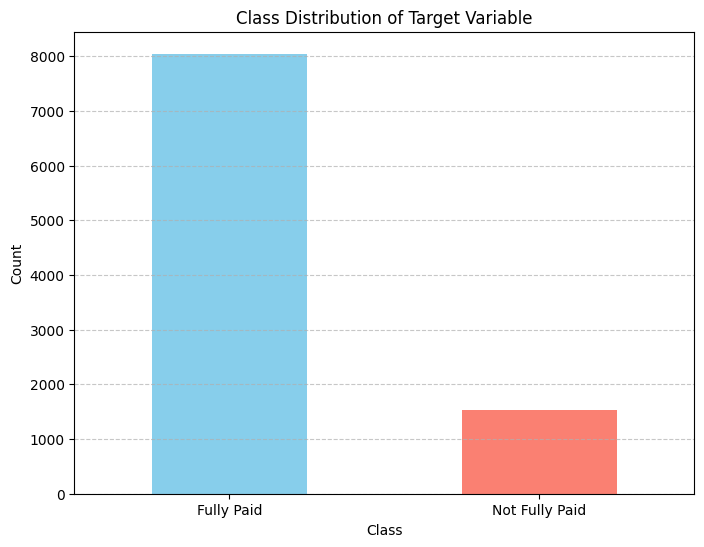

In [245]:
# Class distribution of the target variable
class_distribution = df['not.fully.paid'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution of Target Variable')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Fully Paid', 'Not Fully Paid'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [246]:
df['not.fully.paid'].value_counts()

not.fully.paid
0    8045
1    1533
Name: count, dtype: int64

In [247]:
x = df.drop('not.fully.paid',axis=1)
y = df['not.fully.paid']

In [248]:
x = pd.get_dummies(data=x,
                    drop_first=True)

In [249]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(sampling_strategy='minority') 
x,y=smote.fit_resample(x,y)
y.value_counts()

not.fully.paid
0    8045
1    8045
Name: count, dtype: int64

In [250]:
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

In [251]:
model = RandomForestClassifier(n_estimators=300,
                       random_state=42)

In [252]:
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [253]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


In [254]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6436
           1       1.00      1.00      1.00      6436

    accuracy                           1.00     12872
   macro avg       1.00      1.00      1.00     12872
weighted avg       1.00      1.00      1.00     12872



In [255]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1609
           1       0.86      0.83      0.84      1609

    accuracy                           0.85      3218
   macro avg       0.85      0.85      0.85      3218
weighted avg       0.85      0.85      0.85      3218



In [257]:
# LIME
from lime import lime_tabular as lt
import numpy as np

In [258]:
explainer = lt.LimeTabularExplainer(training_data=np.array(X_train), 
                                    mode = 'classification',
                                    feature_names=X_train.columns,
                                    categorical_features=range(12,19))

In [259]:
exp = explainer.explain_instance(data_row= X_test.loc[13054],
                           predict_fn= model.predict_proba)
exp.show_in_notebook(show_table = True)